{frozendict.frozendict({'input_file': 'b62bd7b261b.c', 'type': 'dead_store', 'classification': frozenset({'UNDER', 'TRUE', 'NEW'}), 'line_number': 16, 'origin': frozenset({'family'})}), frozendict.frozendict({'input_file': 'bc0ffc0e971.c', 'type': 'uninitialized_value', 'classification': frozenset({'FALSE'}), 'line_number': 29, 'origin': frozenset({'family'})}), frozendict.frozendict({'input_file': 'd7e9711760a.c', 'type': 'dead_store', 'classification': frozenset({'TRUE', 'NEW'}), 'line_number': 30, 'origin': frozenset({'family'})}), frozendict.frozendict({'input_file': '1f758a4341a.c', 'type': 'control_flow', 'classification': frozenset({'TRUE', 'NEW'}), 'line_number': 32, 'origin': frozenset({'family'})}), frozendict.frozendict({'input_file': '242f1a34377.c', 'type': 'control_flow', 'classification': frozenset({'OVER', 'TRUE', 'NEW'}), 'line_number': 18, 'origin': frozenset({'family'})}), frozendict.frozendict({'input_file': '36855dcfc98.c', 'type': 'dead_store', 'classification': f

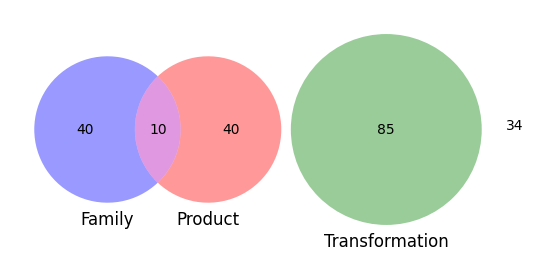

In [7]:
import copy
from typing import Dict
from functools import reduce

import matplotlib.pyplot
from frozendict import frozendict
import csv
import json
import re

from matplotlib_venn import venn3

family_location = "../results/current/family/varbugs_family.json"
product_location = "../results/current/product/varbugs_product.json"
transformation_location = "../results/current/transformation/varbugs_transformation.json"
csv_location = "../notes/classifications.csv"

# Read in results
with open(family_location) as family_file:
    family = json.load(family_file)
    for f in family:
        f['origin'] = 'family'
with open(product_location) as product_file:
    product = json.load(product_file)
    for p in product:
        p['origin'] = 'product'
with open(transformation_location) as transformation_file:
    transformation = json.load(transformation_file)
    for t in transformation:
        t['origin'] = 'transformation'
with open(csv_location) as csv_file:
    csv_reader = csv.DictReader(csv_file)
    rows = list(csv_reader)

all_results = family + product + transformation
for row in rows:
    for r in all_results:
        if r['id'] == row['ID']:
            r['classification'] = frozenset(row['Final Classification'].split("_"))
all_results

# Quick Stats
tp = len([a for a in all_results if 'TRUE' in a['classification']])
tp_new = len([a for a in all_results if 'TRUE' in a['classification'] and 'NEW' in a['classification']])
fp = len([a for a in all_results if 'FALSE' in a['classification']])

# Extract bug information
family_summaries = set()
for f in family:
    family_summaries.add(frozendict({
        "input_file": f["input_file"].split("/")[-1],
        "type": f["taxonomy_type"],
        "classification": f['classification'],
        "line_number": int(re.findall(r":(\d+):\d+", f["err"])[0]),
        "origin": frozenset({"family"})
    }))
print(family_summaries)

product_summaries = set()
for p in product:
    product_summaries.add(frozendict({
        "input_file": p["input_file"].split("/")[-1],
        "line_number": int(p["input_line"]),
        "classification": p["classification"],
        "type": p["taxonomy_type"],
        "origin": frozenset({"product"})
    }))

def transform_linum(linum):
    if "ERROR" in linum:
        transform_linum.counter = transform_linum.counter - 1
        return transform_linum.counter
    else:
        return int(linum.split(":")[0])
transform_linum.counter = 0

transformation_summaries = set()
for t in transformation:
    transformation_summaries.add(frozendict({
        "input_file": t["input_file"].split("/")[-1],
        "line_number": transform_linum(t["original_line"]),
        "classification": t["classification"],
        "type": t["taxonomy_type"],
        "origin": frozenset({"transformation"})
    }))

unique_summaries = set()
all_summaries = transformation_summaries.union(product_summaries).union(family_summaries)
for a in all_summaries:
    filter = {u for u in unique_summaries if u.get("input_file") == a.get("input_file") and u.get("classification") == a.get("classification") and u.get("line_number") == a.get("line_number") and u.get("type") == a.get("type")}
    if len(filter) == 0:
        unique_summaries.add(a)
    if len(filter) == 1:
        print("found a match")
        old = filter.pop()
        unique_summaries.remove(old)
        old.set("origin", old.get("origin").union(a.get("origin")))
        unique_summaries.add(old)
    if len(filter) == 2:
        raise RuntimeError("Too many matches")

def copy_without_origin(d: Dict) -> Dict:
  return frozendict({x: d[x] for x in d if x not in ["origin", "classification"]})

trues = [u for u in unique_summaries if "TRUE" in u.get("classification")]
venn = venn3((
    product_set := {copy_without_origin(u) for u in trues if "product" in u.get("origin")},
    transformation_set := {copy_without_origin(u) for u in trues if "transformation" in u.get("origin")},
    family_set := {copy_without_origin(u) for u in trues if "family" in u.get("origin")}
),
set_labels=("Product", "Transformation", "Family"))
matplotlib.pyplot.text(1, 0, "34")
matplotlib.pyplot.savefig("/Users/austin/git/sugarlyzer-paper/resources/vbdb_tps.png", dpi=300, bbox_inches='tight')

In [62]:
print(f"Number of unique summaries: {len(unique_summaries)}")
print([a.get("origin") for a in unique_summaries if len(a.get("origin")) > 1])
new_tp = [a for a in all_summaries if "TRUE" in a['classification'] and "NEW" in a['classification']]
old_tp = [a for a in all_summaries if "TRUE" in a['classification'] and "NEW" not in a['classification']]
print(f"Total classifications: {len(all_summaries)}")
print(f"New tp: {len(new_tp)}")
print(f"Old tp: {len(old_tp)}")
all_tp = 97 + len(new_tp)

# Individual Precision and Recall
for origin in ['product', 'family', 'transformation']:
    tp = [a for a in all_results if 'TRUE' in a['classification'] and a['origin'] == origin]
    fp = [a for a in all_results if 'FALSE' in a['classification'] and a['origin'] == origin]
    precision = len(tp) / len([a for a in all_results if a['origin'] == origin])
    recall = len(tp) / all_tp
    print(f"Precision of {origin}: {precision}")
    print(f"Recall of {origin}: {recall}")

Number of unique summaries: 36
[]
Total classifications: 345
New tp: 156
Old tp: 63
Precision of product: 0.7972972972972973
Recall of product: 0.233201581027668
Precision of family: 0.7532467532467533
Recall of family: 0.22924901185770752
Precision of transformation: 0.4700854700854701
Recall of transformation: 0.43478260869565216
